In [2]:
import pandas as pd
import numpy as np
from geohash import encode, decode
from sklearn.cluster import DBSCAN
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
import folium
import shap
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./artifacts/clean_df.csv', index_col=0)
# 1. Parse 'destination_lat_lng' into separate lat and lng columns
df['dest_lat'] = round(df['destination_lat_lng'].str.\
    replace('[', '').\
    str.replace(']', '').str.split(',', expand=True)[0].\
        astype(float),6)
df['dest_lng'] = round(df['destination_lat_lng'].str.\
    replace('[', '').\
    str.replace(']', '').str.split(',', expand=True)[1].\
        astype(float),6)
df['day_of_week_n'] = df['day_of_week'].map({'Monday': 0, 
                                             'Tuesday': 1, 
                                             'Wednesday': 2, 
                                             'Thursday': 3, 
                                             'Friday': 4, 
                                             'Saturday': 5, 
                                             'Sunday': 6})
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.drop('datetime_dt', inplace=True, axis=1)
df.reset_index(drop=True, inplace=True)

In [4]:
df.head().T

,0,1,2,3,4
type,UberX,UberX,UberX,UberX,UberX
date,2023-11-11,2023-11-11,2023-11-11,2023-11-11,2023-11-11
time,17:28:00,16:37:00,16:19:00,15:57:00,12:32:00
duration,11 min 32 sec,27 min 43 sec,16 min 18 sec,5 min 29 sec,21 min 33 sec
distance,4.15 km,13.42 km,4.78 km,1.38 km,5.28 km
origin,"Rua Antônio das Chagas, Santo Amaro - São Paul...","Rua Helena, Itaim Bibi - São Paulo - SP, 04552...","Alameda Gabriel Monteiro da Silva, Jardim Amer...","R. Turiassu, Perdizes - São Paulo - SP, 05005-...","Rua Capital Federal, Perdizes - São Paulo - SP..."
destination,"R. Geórgia, Brooklin - São Paulo - SP, 04559-0...","Rua Quipa, Campo Limpo - São Paulo - SP, 05756...","Rua Helena, Itaim Bibi - São Paulo - SP, 04552...","Rua Ministro Godói, Perdizes - São Paulo - SP,...","Av. Rebouças, Bairro Pinheiros - São Paulo - S..."
total_earning,15.01,27.09,13.78,6.69,20.0
base_fare,11.01,27.09,13.78,6.69,20.0
customer_fare,19.97,34.95,22.96,10.96,24.88


In [5]:
corr_matrix = df.select_dtypes(include='number').corr().abs()
corr_matrix = corr_matrix['ted']
corr_matrix.drop('ted', inplace=True)
phase1 = corr_matrix[corr_matrix >= 0.1].index.tolist()

In [6]:
model = XGBRegressor(n_estimators=150)
model.fit(df[phase1], df['ted'])
importances = pd.Series(model.feature_importances_, index=phase1)
importances = importances.sort_values(ascending=False)
cumulative = importances.cumsum() / importances.sum()
phase2 = importances[cumulative <= 1.0].index.tolist()

In [7]:
# Ensure the input data has the same number of features as the model expects
input_data = df[phase2].values
if input_data.shape[1] != model.n_features_in_:
	raise ValueError(f"Expected {model.n_features_in_} features, but got {input_data.shape[1]} features.")

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(input_data)
avg_shap = pd.Series(np.abs(shap_values).mean(0), index=phase2)
phase3 = avg_shap[avg_shap > 0.05 * avg_shap.max()].index.tolist()

In [8]:
mandatory = ['hour_of_day']
final_features = mandatory + phase3

Text(0.5, 1.0, 'Final Feature Correlations')

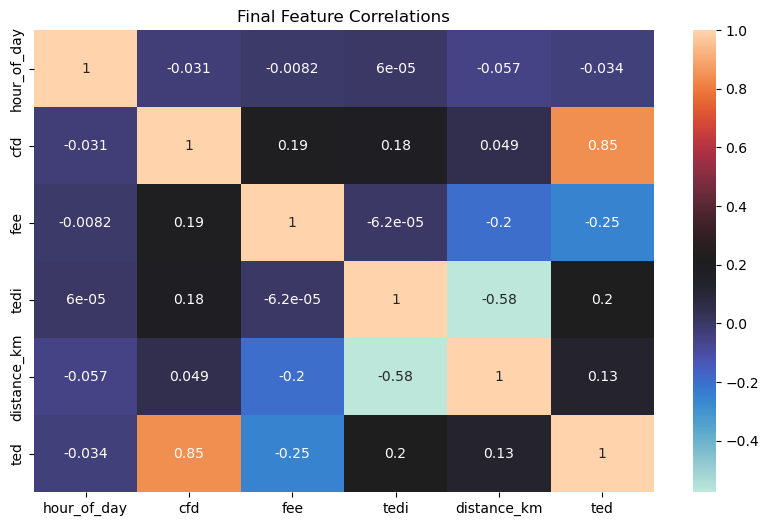

In [9]:
plt.figure(figsize=(10,6))
sns.heatmap(df[final_features+['ted']].corr(), annot=True, cmap='icefire')
plt.title("Final Feature Correlations")

In [19]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators= 352,
 max_depth= 5,
 learning_rate= 0.0747874324956576,
 subsample= 0.6385913084685647)
# objective='reg:squarederror')
# model = XGBRegressor(objective='reg:squarederror')
features = final_features + ['cluster', 'origin_lat', 'origin_lng', 
                             'dest_lat', 'dest_lng']
model.fit(df[features], df['ted'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0747874324956576,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=352, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error

def print_metrics(y_true, y_pred):
    print(f"R2: {r2_score(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"Mean TED Ratio: {(y_pred / y_true).mean():.2f}")

n_splits = 3
gap_minutes = 30  # 30-minute buffer instead of 24h
test_size = 350   # ~12% of total data

tss = TimeSeriesSplit(
    n_splits=n_splits,
    test_size=test_size,
    gap=gap_minutes
)

for fold, (train_idx, test_idx) in enumerate(tss.split(df, df['datetime'])):
    # Split data maintaining temporal order
    X_train = df.iloc[train_idx][features]
    X_test = df.iloc[test_idx][features]
    
    y_train = df.iloc[train_idx]['ted']
    y_test = df.iloc[test_idx]['ted']
    
    # Training/evaluation logic remains same
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"Fold {fold}:")
    print_metrics(y_test, preds)

Fold 0:
R2: 0.86
RMSE: 0.11
MAE: 0.05
Mean TED Ratio: 0.99
Fold 1:
R2: 0.95
RMSE: 0.07
MAE: 0.04
Mean TED Ratio: 1.00
Fold 2:
R2: 0.92
RMSE: 0.08
MAE: 0.05
Mean TED Ratio: 1.02


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0)
    }
    
    model = XGBRegressor(**params)
    score = -1 * cross_val_score(model, df[features], df['ted'], 
                               cv=tss, scoring='neg_mean_absolute_error').mean()
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

In [23]:
import folium 
from folium import plugins

def plot_optimal_locations(hour=8, top_n=10):
    # Create prediction grid using actual origin coordinates
    locations = df[['origin_lat', 'origin_lng']].drop_duplicates()
    print(locations)
    
    # Create feature matrix for predictions
    X_pred = locations.assign(
        hour_of_day=hour,
        cluster=-1,  # Mock cluster value
        dest_lat=locations['origin_lat'],  # Assume same as origin for demo
        dest_lng=locations['origin_lng'],
        distance_km=5  # Mock distance
    )[features]
    
    # Get predictions
    locations['ted_score'] = model.predict(X_pred)
    
    # Create map
    m = folium.Map(location=[locations['origin_lat'].mean(), 
                            locations['origin_lng'].mean()],
                  zoom_start=12)
    
    # Add heatmap layer
    heat_data = [[row['origin_lat'], row['origin_lng'], row['ted_score']] 
                for _, row in locations.nlargest(top_n, 'ted_score').iterrows()]
    
    plugins.HeatMap(heat_data, 
                   radius=20,
                   gradient={0.4: 'blue', 0.6: 'lime', 0.8: 'orange', 1: 'red'}
                  ).add_to(m)
    
    return m

# Generate map for 8 AM
optimal_map = plot_optimal_locations(8)
optimal_map

      origin_lat  origin_lng
0     -23.631046  -46.700975
1     -23.593088  -46.685821
2     -23.567052  -46.677943
3     -23.532765  -46.670508
4     -23.540790  -46.685100
...          ...         ...
2908  -23.536845  -46.728031
2909  -23.621711  -46.687252
2910  -23.625809  -46.661340
2911  -23.497906  -46.634177
2916  -23.712537  -46.546189

[1825 rows x 2 columns]


KeyError: "['cfd', 'fee', 'tedi'] not in index"